In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


# Prepare dataset

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11140603.36it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204945.18it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3677598.38it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6509580.04it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b0716d01120>, <torch.utils.data.dataloader.DataLoader object at 0x7b0716d008e0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


# Linear / Non-linear Baseline models

In [4]:
class Model_0(nn.Module):
  def __init__(self, in_features=28*28, out_features=10, hidden_features=32):
    super().__init__()
    self.layer_stacked = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=hidden_features),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.Linear(in_features=hidden_features, out_features=out_features)
    )
  def forward(self,x):
    return self.layer_stacked(x)

class Model_1(nn.Module):
  def __init__(self, in_features=28*28, out_features=10, hidden_features=32):
    super().__init__()
    self.layer_stacked = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=out_features)
    )
  def forward(self,x):
    return self.layer_stacked(x)

model_0 = Model_0()
model_1 = Model_1()

In [47]:
# helper functions
import numpy as np
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer

torch.manual_seed(42)
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def evaluate(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device
):
  losses = []
  accuracy = []

  # evaluate
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # device agnostic
      X, y = X.to(device), y.to(device)

      # predict
      y_logit = model(X)

      # loss
      losses.append(loss_fn(y_logit, y).cpu().detach().numpy())

      # accuracy
      y_pred = torch.argmax(y_logit, dim=1)
      accuracy.append(accuracy_fn(y_true=y.cpu(), y_pred=y_pred.cpu()))

  mean_loss = np.mean(losses)
  mean_accuracy = np.mean(accuracy)
  print(f"Loss-{mean_loss:.3f};\t Accuracy-{mean_accuracy:.3f}")

def train_step(
    model,
    data_loader,
    loss_fn,
    optimizer,
    accuracy_fn,
    device
):
  # define Loss list
  losses = []

  # train
  model.to(device)
  model.train()

  for X, y in data_loader:
    # device agnostic
    X, y = X.to(device), y.to(device)

    # predict
    y_logit = model(X)

    # loss
    loss = loss_fn(y_logit, y)
    losses.append(loss.cpu().detach().numpy())

    # optimizer zero grad
    optimizer.zero_grad()

    # computer gradient
    loss.backward()

    # optimizer step
    optimizer.step()

  # return mean loss
  return np.mean(losses)

def test_step(
    model,
    data_loader,
    loss_fn,
    optimizer,
    accuracy_fn,
    device
):
  # define lists
  losses = []
  accuracy = []

  # train
  model.to(device)
  model.train()

  # evaluate
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # device agnostic
      X, y = X.to(device), y.to(device)

      # predict
      y_logit = model(X)

      # loss
      losses.append(loss_fn(y_logit, y).cpu().detach().numpy())

      # accuracy
      y_pred = torch.argmax(y_logit, dim=1)
      accuracy.append(accuracy_fn(y_true=y.cpu(), y_pred=y_pred.cpu()))

  # return mean loss and accuracy
  return np.mean(losses), np.mean(accuracy)


In [48]:
print("BASELINE MODEL 0 (LINEAR) TRAINING")
# optimizer / loss
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
loss_fn_0 = torch.nn.CrossEntropyLoss()

# Start the timer
start = timer()

for epoch in range(epochs):
  mean_train_loss = train_step(
    model=model_0,
    data_loader=train_dataloader,
    loss_fn=loss_fn_0,
    optimizer=optimizer_0,
    accuracy_fn=accuracy_score,
    device=device
  )

  mean_test_loss, mean_accuracy = test_step(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn_0,
    optimizer=optimizer_0,
    accuracy_fn=accuracy_score,
    device=device
  )

  print(f"Epoch {epoch+1}:\t Train loss-{mean_train_loss:.3f};\t Test loss-{mean_test_loss:.3f};\t Accuracy-{mean_accuracy:.3f}")

# Calculate training time
end = timer()
total_train_time_model_0 = print_train_time(start=start, end=end, device=device)

BASELINE MODEL 0 (LINEAR) TRAINING
Epoch 1:	 Train loss-0.440;	 Test loss-0.469;	 Accuracy-0.835
Epoch 2:	 Train loss-0.436;	 Test loss-0.468;	 Accuracy-0.838
Epoch 3:	 Train loss-0.431;	 Test loss-0.471;	 Accuracy-0.840
Epoch 4:	 Train loss-0.428;	 Test loss-0.465;	 Accuracy-0.837
Epoch 5:	 Train loss-0.426;	 Test loss-0.468;	 Accuracy-0.832
Train time on cuda: 49.540 seconds


In [49]:
print("BASELINE MODEL 1 (NON-LINEAR) TRAINING")
# optimizer / loss
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
loss_fn_1 = torch.nn.CrossEntropyLoss()

# Start the timer
start = timer()

for epoch in range(epochs):
  mean_train_loss = train_step(
    model=model_1,
    data_loader=train_dataloader,
    loss_fn=loss_fn_1,
    optimizer=optimizer_1,
    accuracy_fn=accuracy_score,
    device=device
  )

  mean_test_loss, mean_accuracy = test_step(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn_1,
    optimizer=optimizer_1,
    accuracy_fn=accuracy_score,
    device=device
  )

  print(f"Epoch {epoch+1}:\t Train loss-{mean_train_loss:.3f};\t Test loss-{mean_test_loss:.3f};\t Accuracy-{mean_accuracy:.3f}")

# Calculate training time
end = timer()
total_train_time_model_1 = print_train_time(start=start, end=end, device=device)

BASELINE MODEL 1 (NON-LINEAR) TRAINING
Epoch 1:	 Train loss-0.628;	 Test loss-0.490;	 Accuracy-0.828
Epoch 2:	 Train loss-0.428;	 Test loss-0.422;	 Accuracy-0.847
Epoch 3:	 Train loss-0.390;	 Test loss-0.424;	 Accuracy-0.851
Epoch 4:	 Train loss-0.367;	 Test loss-0.386;	 Accuracy-0.861
Epoch 5:	 Train loss-0.351;	 Test loss-0.379;	 Accuracy-0.863
Train time on cuda: 50.219 seconds


# CNN

In [57]:
class Model_2(nn.Module):
  def __init__(self, in_shape=1, out_shape=10, hidden_features=16):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=in_shape, out_channels=hidden_features, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=3)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=3)
    )
    self.block_3 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_features*3*3, out_features=out_shape)
    )

  def forward(self,x):
    # print(x.shape)
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.block_3(x)
    # print(x.shape)
    return x

model_2 = Model_2()
# model_2(next(iter(train_dataloader))[0])

In [58]:
print("BASELINE MODEL 2 (CNN) TRAINING")
# optimizer / loss
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
loss_fn_2 = torch.nn.CrossEntropyLoss()

# Start the timer
start = timer()

for epoch in range(epochs):
  mean_train_loss = train_step(
    model=model_2,
    data_loader=train_dataloader,
    loss_fn=loss_fn_2,
    optimizer=optimizer_2,
    accuracy_fn=accuracy_score,
    device=device
  )

  mean_test_loss, mean_accuracy = test_step(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn_2,
    optimizer=optimizer_2,
    accuracy_fn=accuracy_score,
    device=device
  )

  print(f"Epoch {epoch+1}:\t Train loss-{mean_train_loss:.3f};\t Test loss-{mean_test_loss:.3f};\t Accuracy-{mean_accuracy:.3f}")

# Calculate training time
end = timer()
total_train_time_model_2 = print_train_time(start=start, end=end, device=device)

BASELINE MODEL 2 (CNN) TRAINING
Epoch 1:	 Train loss-0.825;	 Test loss-0.459;	 Accuracy-0.834
Epoch 2:	 Train loss-0.388;	 Test loss-0.386;	 Accuracy-0.855
Epoch 3:	 Train loss-0.340;	 Test loss-0.359;	 Accuracy-0.867
Epoch 4:	 Train loss-0.314;	 Test loss-0.329;	 Accuracy-0.877
Epoch 5:	 Train loss-0.298;	 Test loss-0.324;	 Accuracy-0.883
Train time on cuda: 64.511 seconds


In [62]:
print("BASELINE MODEL 0 (LINEAR) EVALUATION")
evaluate(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn_0, accuracy_fn=accuracy_score, device=device)
print("BASELINE MODEL 1 (NON-LINEAR) EVALUATION")
evaluate(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn_1, accuracy_fn=accuracy_score, device=device)
print("BASELINE MODEL 2 (CNN) EVALUATION")
evaluate(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn_2, accuracy_fn=accuracy_score, device=device)

BASELINE MODEL 0 (LINEAR) EVALUATION
Loss-0.468;	 Accuracy-0.832
BASELINE MODEL 1 (NON-LINEAR) EVALUATION
Loss-0.379;	 Accuracy-0.863
BASELINE MODEL 2 (CNN) EVALUATION
Loss-0.324;	 Accuracy-0.883


In [63]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [66]:
import random
# get the class names
class_names = train_data.classes

# get random 9 test samples
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model_2, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

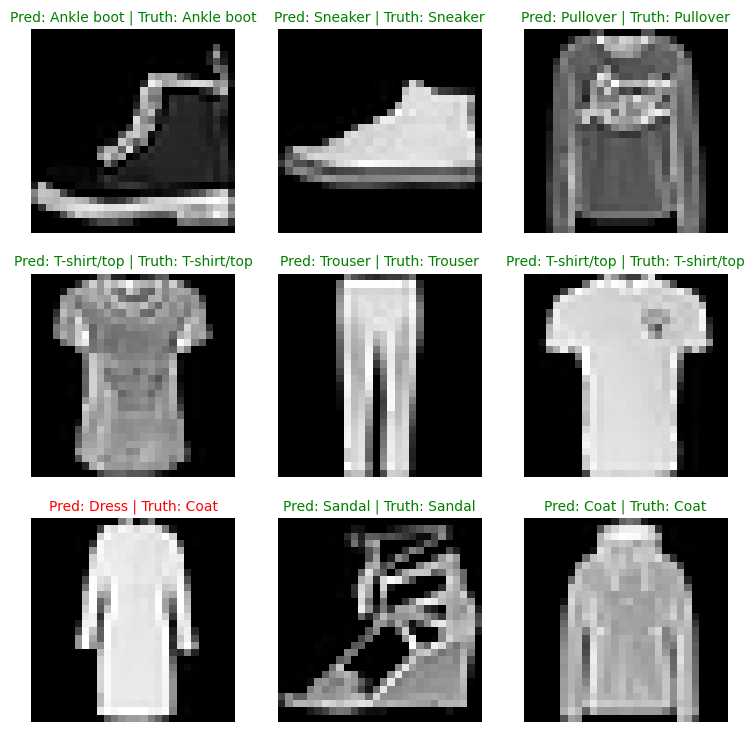

In [67]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);